In [2]:
import statistics

In [3]:
statistics.median([1,1,1,3])

1.0

In [1]:
import pandas as pd 
import urllib.request
import math

In [2]:
def report(df,place=0):
    column_names = df.columns.to_list()
    row = df.iloc[place]
    for i in range(0,len(column_names)):
        print(column_names[i],':',row[i])

#### Загрузка таблицы

In [3]:
url = 'https://service.icecorp.ru/log_ttl_data/data.csv'
with urllib.request.urlopen(url) as response, open('data.csv', 'wb') as out_file:
    data = response.read() # a `bytes` object
    out_file.write(data)

In [4]:
df = pd.read_csv("data.csv",';')
df.fillna(0, inplace=True)

In [5]:
report(df)

id : 15 145 285
date : 05.08.2020 0:00:26
phone : 1297
ttl : bidinfo*a1596574823591b1596574825502c1596574825502d1596585624672e1596585626016f1596574826969g1596574826969h1596574825109i1596574825123j1596585626219
AppVersion : 589
osversion : 6.0
devicename : Xiaomi nikel Redmi Note 4
Backend : https://mpk.iceberg.ru:64443/MasterService/


In [6]:
# Отбор по мастеру
#df = df[df.phone==497]

#### Определим время жизни пакетов

In [7]:
def get_len(last_string):
    try:
        splitters = ['*','a','b','c','d','e','f','g','h','i','j']
        ttl = []
        for splitter in splitters:
            new_string = last_string.split(splitter)
            last_string = new_string[1]
            ttl.append(new_string[0])
        ttl.append(last_string)
        first_value = int(ttl[2])
        last_value = int(ttl[-2:][0])
        return last_value-first_value
    except Exception as e:
        return 0
    

df['dev_len']=df['ttl'].apply(get_len)

report(df)

id : 15 145 285
date : 05.08.2020 0:00:26
phone : 1297
ttl : bidinfo*a1596574823591b1596574825502c1596574825502d1596585624672e1596585626016f1596574826969g1596574826969h1596574825109i1596574825123j1596585626219
AppVersion : 589
osversion : 6.0
devicename : Xiaomi nikel Redmi Note 4
Backend : https://mpk.iceberg.ru:64443/MasterService/
dev_len : 1532


#### Выделим функцию

In [8]:
def get_func(last_string):
    return last_string.split('*')[0]
df['func']=df['ttl'].apply(get_func)

report(df)

id : 15 145 285
date : 05.08.2020 0:00:26
phone : 1297
ttl : bidinfo*a1596574823591b1596574825502c1596574825502d1596585624672e1596585626016f1596574826969g1596574826969h1596574825109i1596574825123j1596585626219
AppVersion : 589
osversion : 6.0
devicename : Xiaomi nikel Redmi Note 4
Backend : https://mpk.iceberg.ru:64443/MasterService/
dev_len : 1532
func : bidinfo


#### Заполним таймеры этапов

In [9]:
def get_timers(last_string,step):
    try:
        splitters = ['*','a','b','c','d','e','f','g','h','i','j']
        ttl = []
        for splitter in splitters:
            new_string = last_string.split(splitter)
            last_string = new_string[1]
            ttl.append(new_string[0])
        ttl.append(last_string)    
        return int(ttl[step])/1000
    except Exception as e:
        return 0

timer_columns = ['a','b','c','d','e','f','g','h','i','j']
for i in range(0,len(timer_columns)):
    column_name = timer_columns[i]
    df[column_name]=df['ttl'].apply(get_timers,step=i+2)

report(df)

id : 15 145 285
date : 05.08.2020 0:00:26
phone : 1297
ttl : bidinfo*a1596574823591b1596574825502c1596574825502d1596585624672e1596585626016f1596574826969g1596574826969h1596574825109i1596574825123j1596585626219
AppVersion : 589
osversion : 6.0
devicename : Xiaomi nikel Redmi Note 4
Backend : https://mpk.iceberg.ru:64443/MasterService/
dev_len : 1532
func : bidinfo
a : 1596574823.591
b : 1596574825.502
c : 1596574825.502
d : 1596585624.672
e : 1596585626.016
f : 1596574826.969
g : 1596574826.969
h : 1596574825.109
i : 1596574825.123
j : 1596585626.219


#### Определим смещение по записи с минимальной длительностью в мс для каждого номера телефона

In [10]:
#phone=497
#mask = ( df['phone'] == phone) & (df['Backend']=='https://mpk.iceberg.ru:61443/MasterService/')
#df[mask].Backend.unique()

In [11]:
'''phone = 497
for backend in df[df['phone'] == phone].Backend.unique():
    mask = ( df['phone'] == phone) & (df['Backend']==backend)
    mr = df[mask].sort_values(by=['dev_len']).iloc[0]
    print(backend,mr.bias_top,mr.bias_bottom)
    '''

"phone = 497\nfor backend in df[df['phone'] == phone].Backend.unique():\n    mask = ( df['phone'] == phone) & (df['Backend']==backend)\n    mr = df[mask].sort_values(by=['dev_len']).iloc[0]\n    print(backend,mr.bias_top,mr.bias_bottom)\n    "

In [12]:
for phone in df["phone"].unique():
    for backend in df[df['phone'] == phone].Backend.unique():
        mask = ( df['phone'] == phone) & (df['Backend']==backend)
        #sel = df[df.phone==phone]
        #sel = sel[sel.dev_len!=0]
        #sel = df[mask]
        mr = df[mask].sort_values(by=['dev_len']).iloc[0] #minimal delay record
        #mr = sel[sel.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
        #mr = df[df.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
        #print(backend,mr)
        bias_top=(mr.h-mr.a-(mr.g-mr.b))/2-(mr.b-mr.a)
        bias_bottom=(mr.f+bias_top-(mr.c+bias_top)-(mr.e-mr.d))/2-(mr.d-(mr.c+bias_top))
        #print(bias_top,bias_bottom)
        #break
        df.loc[mask, 'bias_top'] = bias_top
        df.loc[mask, 'bias_bottom'] = bias_bottom

for phone in df["phone"].unique():
    
    sel = df[df.phone==phone]
    sel = sel[sel.dev_len!=0]
    
    mr = sel[sel.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
    #mr = df[df.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
    
    bias_top=(mr.h-mr.a-(mr.g-mr.b))/2-(mr.b-mr.a)
    bias_bottom=(mr.f+bias_top-(mr.c+bias_top)-(mr.e-mr.d))/2-(mr.d-(mr.c+bias_top))
    df.loc[df['phone'] == phone, 'bias_top'] = bias_top
    df.loc[df['phone'] == phone, 'bias_bottom'] = bias_bottom

#### Вычислим время между инстанциями

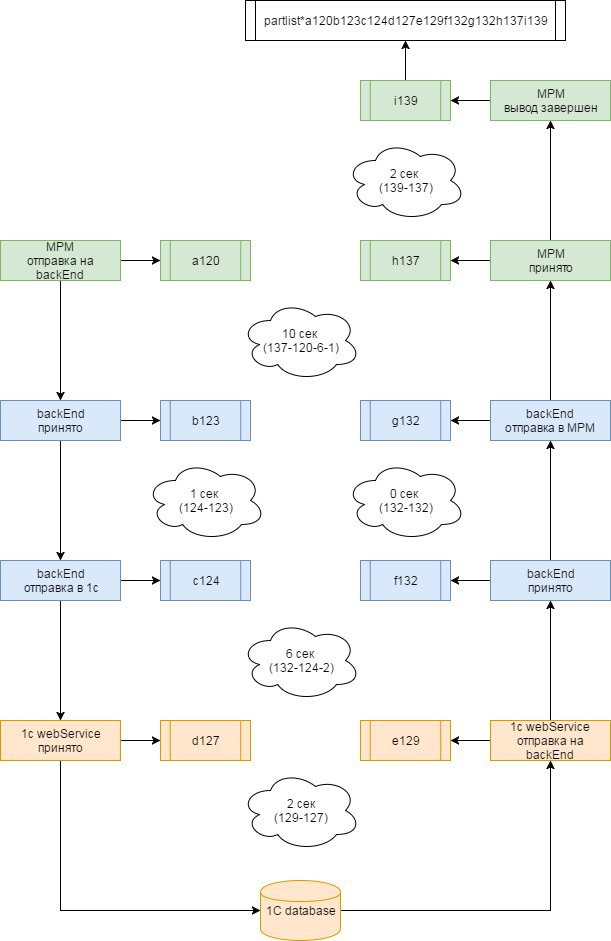

In [13]:
df['ab_mrm_to_back']      = df.b - df.a + df.bias_top    
df['bc_back_to_back']     = df.c - df.b
df['cd_back_to_1c']       = df.d - df.c + df.bias_bottom - df.bias_top
df['de_1c_to_1c']         = df.e - df.d
df['ef_1c_to_back']       = df.f - df.e + df.bias_top - df.bias_bottom
df['fg_back_to_back']     = df.g - df.f
df['gh_back_to_mrm']      = df.h - df.g - df.bias_top
df['hi_mrm_to_mrm']       = df.i - df.h

In [14]:
df['full_len']=df['ab_mrm_to_back']+df['bc_back_to_back']+df['cd_back_to_1c']+df['de_1c_to_1c']+df['ef_1c_to_back']+df['fg_back_to_back']+df['gh_back_to_mrm']+df['hi_mrm_to_mrm']
report(df,0)

id : 15 145 285
date : 05.08.2020 0:00:26
phone : 1297
ttl : bidinfo*a1596574823591b1596574825502c1596574825502d1596585624672e1596585626016f1596574826969g1596574826969h1596574825109i1596574825123j1596585626219
AppVersion : 589
osversion : 6.0
devicename : Xiaomi nikel Redmi Note 4
Backend : https://mpk.iceberg.ru:64443/MasterService/
dev_len : 1532
func : bidinfo
a : 1596574823.591
b : 1596574825.502
c : 1596574825.502
d : 1596585624.672
e : 1596585626.016
f : 1596574826.969
g : 1596574826.969
h : 1596574825.109
i : 1596574825.123
j : 1596585626.219
bias_top : -1.878499984741211
bias_bottom : -10801.0
ab_mrm_to_back : 0.03250002861022949
bc_back_to_back : 0.0
cd_back_to_1c : 0.04849982261657715
de_1c_to_1c : 1.3440001010894775
ef_1c_to_back : 0.07450008392333984
fg_back_to_back : 0.0
gh_back_to_mrm : 0.01849985122680664
hi_mrm_to_mrm : 0.01399993896484375
full_len : 1.5319998264312744


#### График по операторам

In [15]:
def plot_operators(df):
    
    df['oper']=(df.phone/10000000).apply(int)
    df.oper.unique()
    
    # mrm to backend
    graphic = df[df.func=='bidphotoadd'].groupby('oper').median().sort_values('ab_mrm_to_back').plot(
        y=['ab_mrm_to_back'],
        kind='bar',
        title = 'bidphotoadd',
        figsize=(15,4)
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
    
    # backend to mrm
    graphic = df[df.func=='bidinfo'].groupby('oper').median().sort_values('gh_back_to_mrm').plot(
        y=['gh_back_to_mrm'],
        kind='bar',
        title = 'bidinfo',
        figsize=(15,4)
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
    
#plot_operators(df)

#### График по устройствам

In [16]:
def plot_versions(df,func):
    #for func in df['func'].unique():
    sel = df[df.func==func].groupby('devicename').median().sort_values('ab_mrm_to_back')
    #graphic = df[df.func==func].groupby('devicename').median().sort_values('ab_mrm_to_back').plot(
    #graphic = sel[sel.ab_mrm_to_back>2].plot(
    graphic = sel.plot(
        y=[
            'ab_mrm_to_back',
            #'gh_back_to_mrm',
            #'hi_mrm_to_mrm'
        ],
        kind='bar',
        title = func,
        #subplots=True,
        figsize=(30,10),
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")

#plot_versions(df,'bidphotoadd')
#plot_versions(df,'bidlist')
#plot_versions(df,'bidinfo')

#### График по версиям ОС

In [17]:
def plot_versions(df,func):
    #for func in df['func'].unique():
    graphic = df[df.func==func].groupby('osversion').median().plot(
        y=[
            'ab_mrm_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm'
        ],
        kind='bar',
        title = func,
        #subplots=True,
        figsize=(15,6),
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")

#plot_versions(df,'bidphotoadd')
#plot_versions(df,'bidlist')
#plot_versions(df,'bidinfo')

#### График по версиям приложения

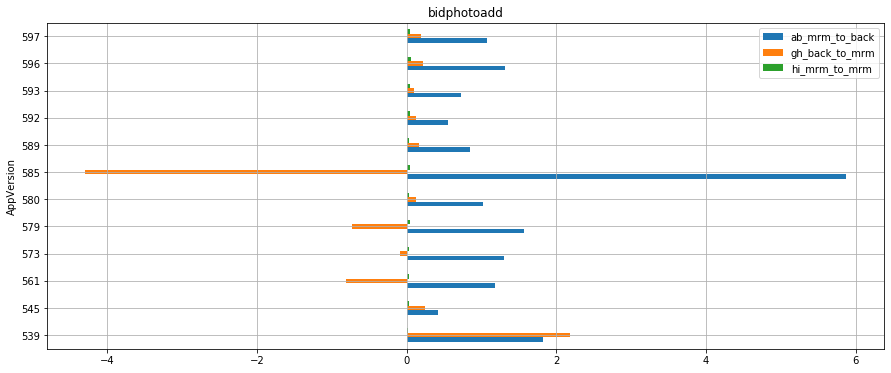

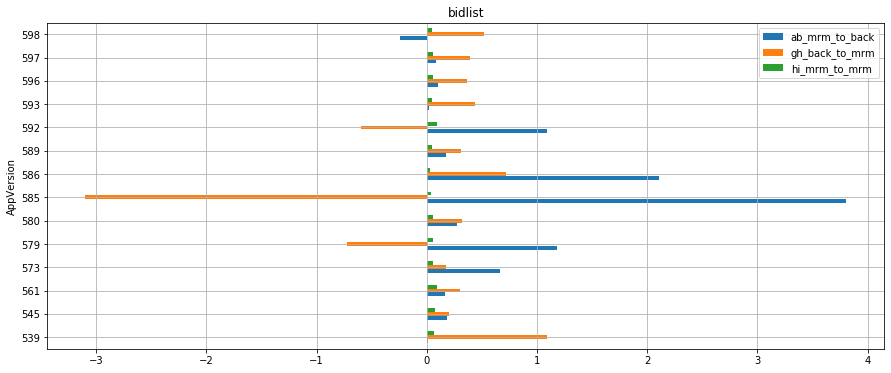

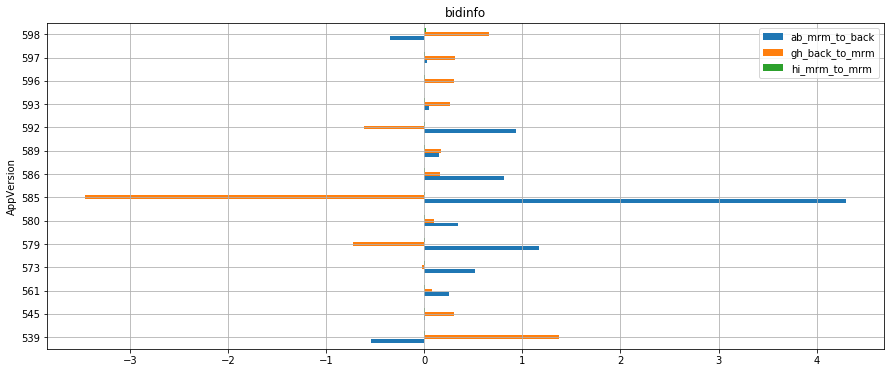

In [32]:
def plot_versions(df,func):
    #for func in df['func'].unique():
    graphic = df[df.func==func].groupby('AppVersion').median().plot(
        y=[
            'ab_mrm_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm'
        ],
        kind='barh',
        title = func,
        #subplots=True,
        figsize=(15,6),
        grid=True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")

plot_versions(df,'bidphotoadd')
plot_versions(df,'bidlist')
plot_versions(df,'bidinfo')

#### Относительное кол-во длительный запросов

In [19]:
def long_query():
    treshold = 4
    mask = ( df['func'] == 'bidlist') & (df['full_len']>treshold)
    print('Всего записей:',len(df))
    print('Превышают',treshold,"сек.:",len(df[mask]))
    print('Или',math.ceil(len(df[mask])/len(df)*100),"%")
#long_query()

#### Топ длительных запросов

In [20]:
def top_longest():
    #df[df.func=='bidlist'].sort_values('dev_len',ascending=False).head(12).date
    #len(df[df.func=='bidlist'].sort_values('dev_len',ascending=False).head(33).groupby('date').max())
    #df[df.func=='bidlist'].dev_len.median()
    func = 'bidlist'
    sel = df[df.func==func].sort_values('dev_len',ascending=False).head(33).groupby('date').max().sort_values('dev_len',ascending=True)
    #sel.drop(['id','phone','ttl'], axis=1, inplace=True)
    sel[[
        #   'date',
        'dev_len',
        'ab_mrm_to_back',
        'bc_back_to_back',
        'cd_back_to_1c',
        'de_1c_to_1c',
        'ef_1c_to_back',
        'fg_back_to_back',
        'gh_back_to_mrm',
        'hi_mrm_to_mrm',
    ]].to_excel("output.xlsx")  
#top_longest()

#### Самые длительные запросы

In [25]:
report(df[df.func=='bidlist'].sort_values('dev_len',ascending=False).head(1))

id : 15 155 997
date : 05.08.2020 14:55:03
phone : 1771
ttl : bidlist*a1596628180916b1596628191109c1596628191109d1596638990266e1596638995547f1596628196663g1596628196678h1596628500193i1596628500314j1596639303241
AppVersion : 589
osversion : 10
devicename : samsung a31ser SM-A315F
Backend : https://mpk.iceberg.ru:64443/MasterService/
dev_len : 319398
func : bidlist
a : 1596628180.916
b : 1596628191.109
c : 1596628191.109
d : 1596638990.266
e : 1596638995.547
f : 1596628196.663
g : 1596628196.678
h : 1596628500.193
i : 1596628500.314
j : 1596639303.241
bias_top : -0.4794999361038208
bias_bottom : -10799.609499931335
ab_mrm_to_back : 9.713500142097473
bc_back_to_back : 0.0
cd_back_to_1c : 0.027000069618225098
de_1c_to_1c : 5.2809998989105225
ef_1c_to_back : 0.24600017070770264
fg_back_to_back : 0.014999866485595703
gh_back_to_mrm : 303.994500041008
hi_mrm_to_mrm : 0.12099981307983398
full_len : 319.39800000190735


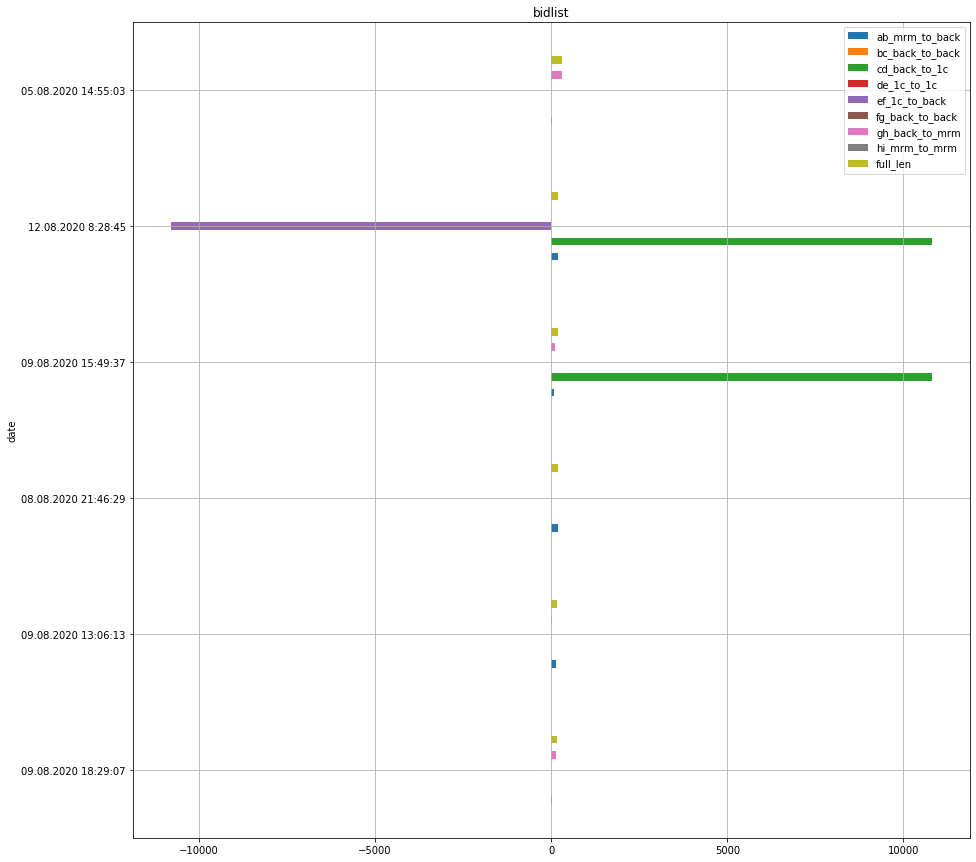

In [21]:
def plot_longest(df):
    func = 'bidlist'
    #df[df.func==func].sort_values('dev_len',ascending=False).head(20)
    #df['day'] = df['date'].str.split().str[0]
    
    #for func in df['func'].unique():
    #graphic = df[df.func==func].groupby('AppVersion').median().plot(
    #graphic = df.groupby('day').median().plot(        
    #graphic = df[df.func==func].groupby('day').median().plot(
    graphic = df[df.func==func].sort_values('dev_len',ascending=False).head(10).groupby('date').max().sort_values('dev_len',ascending=True).plot(        
        y=[
            'ab_mrm_to_back',
            'bc_back_to_back',
            'cd_back_to_1c',
            'de_1c_to_1c',
            'ef_1c_to_back',
            'fg_back_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm',
            'full_len'
        ],
        kind='barh',
        title = func,
        #subplots=True,
        figsize=(15,15),
        grid=True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
plot_longest(df)

#### График по бэкендам

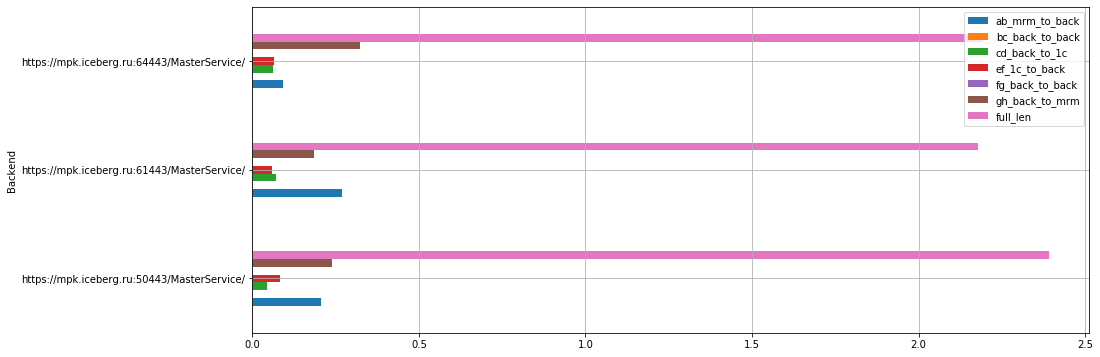

In [22]:
def plot_backends(df):
    
    #df['day'] = df['date'].str.split().str[0]
    #func = 'bidlist'
    #for func in df['func'].unique():
    #graphic = df[df.func==func].groupby('AppVersion').median().plot(
    #graphic = df.groupby('day').median().plot(        
    #graphic = df[df.func==func].groupby('Backend').median().plot(
    graphic = df.groupby('Backend').median().plot(
        y=[
            'ab_mrm_to_back',
            'bc_back_to_back',
            'cd_back_to_1c',
            #'de_1c_to_1c',
            'ef_1c_to_back',
            'fg_back_to_back',
            'gh_back_to_mrm',
            #'hi_mrm_to_mrm',
            'full_len'
        ],
        kind='barh',
        #title = func,
        #subplots=True,
        figsize=(15,6),
        grid=True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
plot_backends(df)

#### График по датам

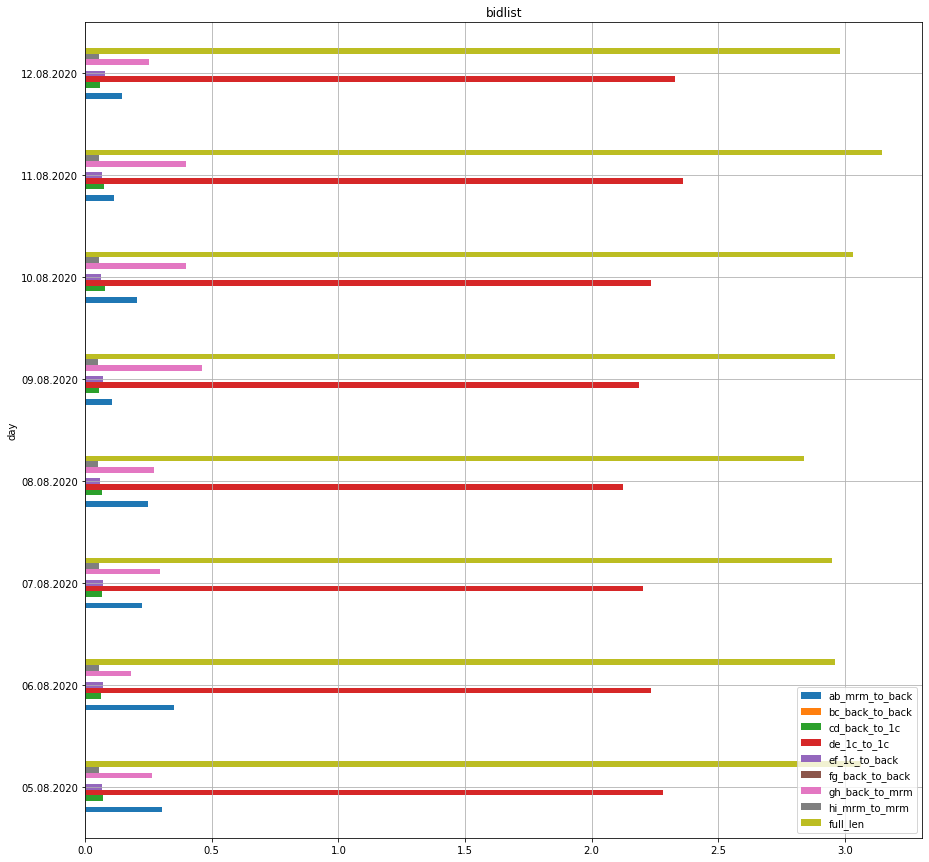

In [29]:
def plot_dates(df):
    
    df['day'] = df['date'].str.split().str[0]
    func = 'bidlist'
    #for func in df['func'].unique():
    #graphic = df[df.func==func].groupby('AppVersion').median().plot(
    #graphic = df.groupby('day').median().plot(        
    graphic = df[df.func==func].groupby('day').median().plot(
        y=[
            'ab_mrm_to_back',
            'bc_back_to_back',
            'cd_back_to_1c',
            'de_1c_to_1c',
            'ef_1c_to_back',
            'fg_back_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm',
            'full_len'
        ],
        kind='barh',
        title = func,
        #subplots=True,
        figsize=(15,15),
        grid = True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
plot_dates(df)